# Azure AutoML for Images
## AutoML for Images to train and a deploy an instance segmentation model (Part 1)

Important: This feature is currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews.

Serge Retkowsky | serge.retkowsky@microsoft.com | V1 28-June-2022

In this notebook you will:

- Create an Azure ML experiment
- Download some images files to train an instances segmentation model. In this example we will try to detect scratches from a metal piece.
- We will do the lalelling part usign Azure ML Data Labelling on the images
- Use AutoML for Images to build and train an instance segmentation model
- Do some advanced hyperparameter tuning using AutoML for Images advanced options
- Deploy the computer vision model into Azure Kubernetes Service
- You will test the model in a separate notebook

AutoML for Images links:
What is AutoML for Images?<br>
https://docs.microsoft.com/en-us/azure/machine-learning/concept-automated-ml#computer-vision-preview
<br><br>
Algorithms<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms
<br><br>
Tutorials<br>
https://docs.microsoft.com/en-us/azure/machine-learning/v1/tutorial-auto-train-image-models-v1
<br><br>
ONNX<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-inference-onnx-automl-image-models?tabs=multi-class
<br><br>
How to use AutoML for Images?<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-automl-small-object-detect
https://docs.microsoft.com/en-us/azure/machine-learning/v1/how-to-auto-train-image-models-v1

In [1]:
import datetime
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import requests
import uuid
import azureml.core
from IPython.display import display_javascript, display_html, display
from azureml.core import Workspace, Datastore, Dataset
from matplotlib.lines import Line2D
from PIL import Image
import humanize

In [2]:
import sys
print("Python version =", sys.version)

Python version = 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [3]:
print("Today:", datetime.datetime.now())

Today: 2022-06-27 12:18:18.804012


In [4]:
print("This notebooks was made using Azure ML version 1.41")
print("You are using Azure ML =", azureml.core.VERSION)

This notebooks was made using Azure ML version 1.41
You are using Azure ML = 1.41.0


In [5]:
# Your local environment
import platform
import socket
import re
import uuid
import json
import psutil
import logging


def getSystemInfo():
    try:
        info = {}
        info['Platform'] = platform.system()
        info['Platform-release'] = platform.release()
        info['Platform-version'] = platform.version()
        info['Architecture'] = platform.machine()
        info['Hostname'] = socket.gethostname()
        info['IP-address'] = socket.gethostbyname(socket.gethostname())
        info['MAC-address'] = ':'.join(
            re.findall('..', '%012x' % uuid.getnode()))
        info['Processor'] = platform.processor()
        info['RAM'] = str(round(psutil.virtual_memory().total /
                                (1024.0**3))) + " Gb"
        return json.dumps(info)

    except Exception as e:
        logging.exception(e)


print("Your local environment:")
json.loads(getSystemInfo())

Your local environment:


{'Platform': 'Linux',
 'Platform-release': '5.4.0-1077-azure',
 'Platform-version': '#80~18.04.1-Ubuntu SMP Wed Apr 13 02:07:09 UTC 2022',
 'Architecture': 'x86_64',
 'Hostname': 'standardd13',
 'IP-address': '127.0.0.1',
 'MAC-address': '60:45:bd:90:9b:99',
 'Processor': 'x86_64',
 'RAM': '55 Gb'}

In [6]:
def createdir(MYDIR):

    # Create directory
    if not os.path.exists(MYDIR):  # Only if dir not exist
        print("Dir:", MYDIR, "does not exist!")
        print("So let's create dir:", MYDIR)
        os.mkdir(MYDIR)
        print("Done!")

    else:
        print("Dir:", MYDIR, "exist. So let's use it!")

In [7]:
def listfiles(MYDIR):

    # List files from a directory
    nb = 1
    print("Files in directory:", MYDIR, "\n")
    for file in os.scandir(MYDIR):
        print(nb, '\t', datetime.datetime.fromtimestamp(file.stat().st_atime),
              '\t', file.name, humanize.naturalsize(file.stat().st_size))
        nb += 1

## 1. Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription or load an existing workspace.

In [8]:
your_azure_id = "tobereplaced"
your_azureml_workspace_resourcegroup = "tobereplaced"
your_azurelml_workspace = "tobereplaced"

In [9]:
subscription_id = os.environ.get("SUBSCRIPTION_ID", your_azure_id)
resource_group = os.environ.get("RESOURCE_GROUP",
                                your_azureml_workspace_resourcegroup)
workspace_name = os.environ.get("WORKSPACE_NAME", your_azurelml_workspace)

In [10]:
from azureml.core import Workspace

try:
    ws = Workspace(subscription_id=subscription_id,
                   resource_group=resource_group,
                   workspace_name=workspace_name)

    ws.write_config()
    print("[OK] Workspace configuration saved.")

except:
    print("[Error] Workspace not found!")

[OK] Workspace configuration saved.


In [11]:
try:
    print("Loading Azure ML workspace config...")
    ws = Workspace.from_config()
    print("\n[OK] Workspace is available:")
    print("Azure ML workspace:", ws.name)
    print("Azure ML resource group:", ws.resource_group)

except:
    print("[Error] Cannot load configuration")

Loading Azure ML workspace config...

[OK] Workspace is available:
Azure ML workspace: azuremlvision
Azure ML resource group: azuremlvision-rg


In [12]:
#ws.get_details()

## 2. Azure ML GPU Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [13]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "AutoML-GPU"

t1 = datetime.datetime.now()

try:
    compute_target = ws.compute_targets[cluster_name]
    print(t1, "Found existing compute target.")

except KeyError:
    print(t1, "Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6",
        idle_seconds_before_scaledown=1800,
        min_nodes=0,
        max_nodes=4,
    )
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20
)

print()
print("Done in:", datetime.datetime.now() - t1)

2022-06-27 12:19:00.082114 Creating a new compute target...
InProgress..
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned

Done in: 0:01:04.448220


In [14]:
print("Azure ML GPU compute cluster is available:", compute_target.name)

Azure ML GPU compute cluster is available: AutoML-GPU


## 3. Azure ML Experiment Setup
Create an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#experiments) in your workspace to track your model training runs

In [15]:
from azureml.core import Experiment

experiment_name = "AutoML-InstanceSegmentation-MetalScratchProject"
experiment = Experiment(ws, name=experiment_name)

In [16]:
print("Results will be available in this Azure ML experiment:",
      experiment_name)

experiment

Results will be available in this Azure ML experiment: AutoML-InstanceSegmentation-MetalScratchProject


Name,Workspace,Report Page,Docs Page
AutoML-InstanceSegmentation-MetalScratchProject,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## 4. Dataset with input Training Data

In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset). You can either use a dataset that you have exported from a [Data Labeling](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-label-data) project, or create a new Tabular Dataset with your labeled training data.

We need to label the scratches from the images. You can use Azure Data Labelling. Images should be stored into an Azure Storage Account and then you can create a data labelling instance segmentation project to label the polygons from the scratches you want to detect.

Initial images are available here: https://github.com/retkowsky/CustomVision_Datasets/blob/master/scratch_images.zip

In [17]:
from azureml.core import Workspace, Dataset
import azureml.contrib.dataset

# Name of your labelled dataset
fulldataset = Dataset.get_by_name(ws, name='metal_20220623_115437')
df = fulldataset.to_pandas_dataframe()  # Convert it to a pandas dataframe

In [18]:
df.shape

(24, 7)

### This is the labelled dataset for an instance segmentation project

In [21]:
df.head(10)

,image_url,label,label_confidence,labeler,labeling_time_in_seconds,image_height,image_width
0,metal/metal (24).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...","[1.0, 1.0]",Serge Retkowsky,30.42,700,700
1,metal/metal (20).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...",[1.0],Serge Retkowsky,26.60,700,700
2,metal/metal (10).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...",[1.0],Serge Retkowsky,18.67,700,700
3,metal/metal (18).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...","[1.0, 1.0, 1.0]",Serge Retkowsky,22.20,700,700
4,metal/metal (8).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...",[1.0],Serge Retkowsky,8.04,700,700
5,metal/metal (13).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...","[1.0, 1.0]",Serge Retkowsky,10.63,700,700
6,metal/metal (22).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...",[1.0],Serge Retkowsky,9.43,700,700
7,metal/metal (9).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...",[1.0],Serge Retkowsky,11.65,700,700
8,metal/metal (2).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...","[1.0, 1.0]",Serge Retkowsky,16.28,700,700
9,metal/metal (11).png,"[{'label': 'scratch', 'isCrowd': False, 'polyg...","[1.0, 1.0]",Serge Retkowsky,16.60,700,700


In [22]:
df.describe()

,labeling_time_in_seconds,image_height,image_width
count,24.000000,24.0,24.0
mean,13.594167,700.0,700.0
std,6.424904,0.0,0.0
min,6.420000,700.0,700.0
25%,8.190000,700.0,700.0
50%,11.620000,700.0,700.0
75%,16.360000,700.0,700.0
max,30.420000,700.0,700.0


## 5. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML Image run are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-your-experiment-settings) for the details on the parameters that can be used and their values.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values for a given model to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This allows an iterative approach, as with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially, and  you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say `maskrcnn`), you can specify the config for your AutoML Image runs as follows:

Supported Algorithms https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

### Let's choose an instance segmentation algorithm

In [23]:
#CVALGO = "maskrcnn_resnet18_fpn"
CVALGO = "maskrcnn_resnet34_fpn"
#CVALGO = "maskrcnn_resnet50_fpn"
#CVALGO = "maskrcnn_resnet101_fpn"
#CVALGO = "maskrcnn_resnet152_fpn"

In [24]:
print("Starting to build an instance segmentation model using:", CVALGO)

Starting to build an instance segmentation model using: maskrcnn_resnet34_fpn


In [25]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

In [28]:
# This is an instance segmentation task

automl_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_INSTANCE_SEGMENTATION,
    compute_target=compute_target,  # Azure ML GPU cluster to use
    training_data=fulldataset,  # images
    # validation_data = validation_dataset, # by default 20% is the for the validation or you can specify a val dataset
    experiment_timeout_hours=0.5,  # Timeout in hours
    hyperparameter_sampling=GridParameterSampling(
        {"model_name": choice(CVALGO)}),
    iterations=1,  # 1 is for the default hyperparameter values
)

## 6. Submitting an AutoML run for Computer Vision tasks
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train a vision model using your training dataset.

In [29]:
t1 = datetime.datetime.now()
print("Running AutoML for Images...\n")

automl_image_run = experiment.submit(automl_config)
automl_image_run.wait_for_completion(wait_post_processing=True)

print("\nDone in:", datetime.datetime.now() - t1)

Running AutoML for Images...

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutoML-InstanceSegmentation-MetalScratchProject,AutoML_45460856-9191-40e7-b2ed-2f8f863aa599,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Done in: 0:11:37.159085


> Model can be improved by adding more labelled images. 

## [Optional] Hyperparameter sweeping for your AutoML models for computer vision tasks

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for learning_rate, optimizer, etc., to generate a model with the optimal 'accuracy'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target, which has been previously set up using 4 nodes.  Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

## 7. Model results

In [30]:
MODEL_DIR = 'model'
createdir(MODEL_DIR)

Dir: model does not exist!
So let's create dir: model
Done!


In [31]:
automl_image_run.get_properties

<bound method Run.get_properties of Run(Experiment: AutoML-InstanceSegmentation-MetalScratchProject,
Id: AutoML_45460856-9191-40e7-b2ed-2f8f863aa599,
Type: automl,
Status: Completed)>

In [32]:
best_child_run = automl_image_run.get_best_child()
bestautoml_algorithm = best_child_run.properties['run_algorithm']
print("CV best automl algorithm =", bestautoml_algorithm)

CV best automl algorithm = maskrcnn_resnet34_fpn


In [33]:
allmetrics_df = pd.DataFrame(automl_image_run.get_metrics())
allmetrics_df

,per_label_metrics,mean_average_precision,recall,precision
0,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.00000,0.00000,0.00000
1,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.02222,0.11111,0.04167
2,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.30556,0.33333,0.25000
3,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.50638,0.88889,0.05128
4,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.58889,0.66667,0.24000
5,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.52381,0.55556,0.17857
6,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.37778,0.44444,0.57143
7,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.67521,0.77778,0.12069
8,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.70370,0.77778,0.50000
9,"{0: {'precision': -1.0, 'recall': -1.0, 'avera...",0.77518,0.88889,0.40000


In [57]:
model_meanverageprecision = allmetrics_df['mean_average_precision'].values[allmetrics_df.shape[0] - 1]
model_recall = allmetrics_df['recall'].values[allmetrics_df.shape[0] - 1]
model_precision = allmetrics_df['precision'].values[allmetrics_df.shape[0] - 1]

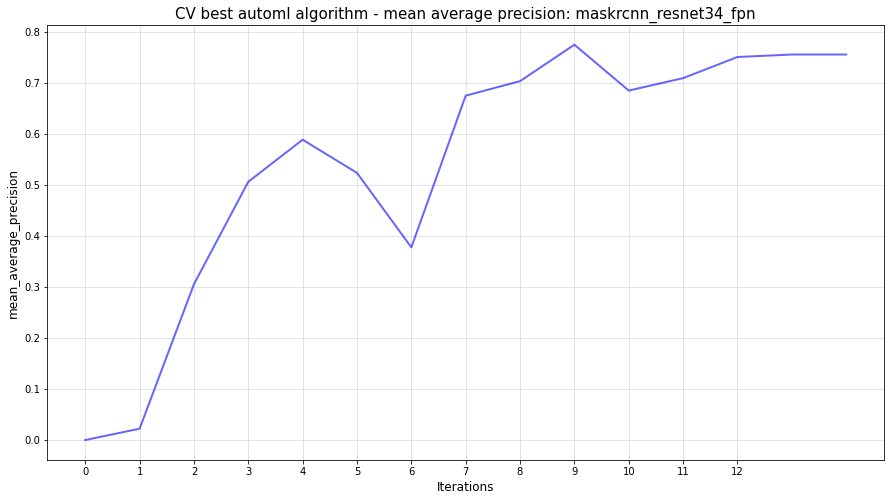

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 8))
plt.plot(allmetrics_df['mean_average_precision'], 'b-', lw=2, alpha=0.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('mean_average_precision', fontsize=12)
plt.title('CV best automl algorithm - mean average precision: ' +
          bestautoml_algorithm, fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 13, 1))

plt.savefig(MODEL_DIR + '/' + bestautoml_algorithm + \
            '_bestautoml_meanaverageprecision.png')
plt.show()

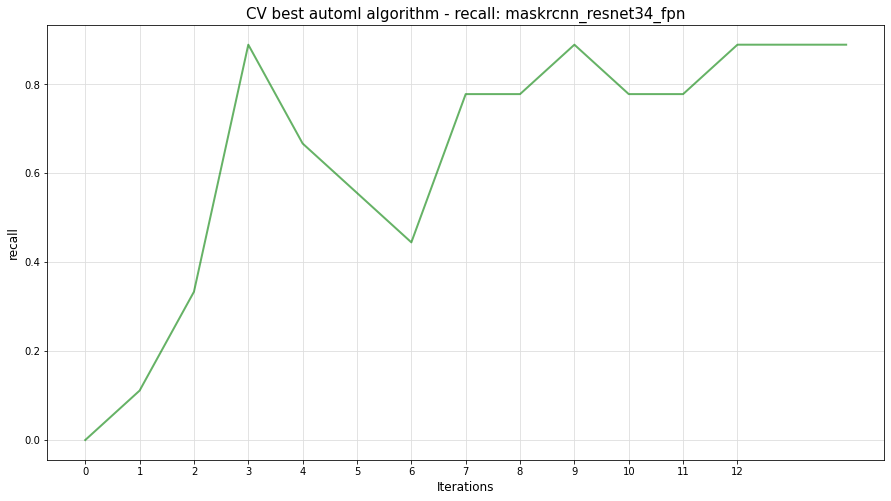

In [36]:
%matplotlib inline

plt.figure(figsize=(15, 8))
plt.plot(allmetrics_df['recall'], 'g-', lw=2, alpha=0.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('recall', fontsize=12)
plt.title('CV best automl algorithm - recall: ' +
          bestautoml_algorithm, fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 13, 1))

plt.savefig(MODEL_DIR + '/' + bestautoml_algorithm + '_recall.png')
plt.show()

In [37]:
listfiles(MODEL_DIR)

Files in directory: model 

1 	 2022-06-27 13:16:18.466302 	 maskrcnn_resnet34_fpn_bestautoml_meanaverageprecision.png 29.8 kB
2 	 2022-06-27 13:16:30.680385 	 maskrcnn_resnet34_fpn_recall.png 29.9 kB


## 8. Register the model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [38]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + "_HD")
hyperdrive_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoML-InstanceSegmentation-MetalScratchProject,AutoML_45460856-9191-40e7-b2ed-2f8f863aa599_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [60]:
model_desc = "Instance Segmentation CV model " + bestautoml_algorithm +\
    " for detecting metal scratches"

model_tags = {"Data": "Images",
              "Context": "Metal Scratches Detection",
              "Algorithm": bestautoml_algorithm,
              "Task": "Instance Segmentation",
              "MAP" : model_meanverageprecision,
              "Precision" : model_meanverageprecision,
              "Recall" : model_meanverageprecision,
              "Framework": "Azure ML AutoML for Images"}

In [67]:
print("Registering the model\n")

best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties["model_name"]

model = best_child_run.register_model(model_name=model_name,
                                      # Model to register (PyTorch format)
                                      model_path="outputs/model.pt",
                                      description=model_desc,
                                      tags=model_tags)
print("Done.")

Registering the model

Done.


In [68]:
model.id

'AutoML4546085690:3'

In [69]:
model.version

3

In [70]:
model.description

'Instance Segmentation CV model maskrcnn_resnet34_fpn for detecting metal scratches'

In [71]:
model.tags

{'Data': 'Images',
 'Context': 'Metal Scratches Detection',
 'Algorithm': 'maskrcnn_resnet34_fpn',
 'Task': 'Instance Segmentation',
 'MAP': '0.75589',
 'Precision': '0.75589',
 'Recall': '0.75589',
 'Framework': 'Azure ML AutoML for Images'}

### Download artifacts

In [72]:
# PyTorch model
best_child_run.download_file("outputs/model.pt",
                             output_file_path=MODEL_DIR + "/model.pt")

In [73]:
# Computer Vision Labels
best_child_run.download_file("train_artifacts/labels.json",
                             output_file_path=MODEL_DIR + "/labels.json")

In [74]:
with open(os.path.join('model/labels.json'), 'r') as f:
    print(f.read())

["--bg--", "scratch"]


In [75]:
# ONNX model (for local inference)
best_child_run.download_file("train_artifacts/model.onnx",
                             output_file_path=MODEL_DIR + "/model.onnx")

In [76]:
# Model metrics
best_child_run.download_file("train_artifacts/per_label_metrics.json",
                             output_file_path=MODEL_DIR +
                             "/per_label_metrics.json")

In [77]:
with open(os.path.join('model/per_label_metrics.json'), 'r') as f:
    print(f.read())

{"--bg--": {"precision": [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], "recall": [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], "average_precision": [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}, "scratch": {"precision": [-1.0, 0.04167, 0.25, 0.05128, 0.24, 0.17857, 0.57143, 0.12069, 0.5, 0.4, 0.41176, 0.38889, 0.47059, 0.5, 0.5], "recall": [0.0, 0.11111, 0.33333, 0.88889, 0.66667, 0.55556, 0.44444, 0.77778, 0.77778, 0.88889, 0.77778, 0.77778, 0.88889, 0.88889, 0.88889], "average_precision": [0.0, 0.02222, 0.30556, 0.50638, 0.58889, 0.52381, 0.37778, 0.67521, 0.7037, 0.77518, 0.68519, 0.7096, 0.75101, 0.75589, 0.75589]}}


In [78]:
# Training datasets
best_child_run.download_file("train_artifacts/train_df.csv",
                             output_file_path=MODEL_DIR + "/train_df.csv")

In [79]:
# Validation datasets
best_child_run.download_file("train_artifacts/val_df.csv",
                             output_file_path=MODEL_DIR + "/val_df.csv")

In [80]:
listfiles(MODEL_DIR)

Files in directory: model 

1 	 2022-06-27 13:25:51.811091 	 labels.json 21 Bytes
2 	 2022-06-27 13:16:18.466302 	 maskrcnn_resnet34_fpn_bestautoml_meanaverageprecision.png 29.8 kB
3 	 2022-06-27 13:16:30.680385 	 maskrcnn_resnet34_fpn_recall.png 29.9 kB
4 	 2022-06-27 13:25:56.189611 	 model.onnx 164.3 MB
5 	 2022-06-27 13:25:51.487272 	 model.pt 327.3 MB
6 	 2022-06-27 13:25:56.539414 	 per_label_metrics.json 765 Bytes
7 	 2022-06-27 13:25:56.870227 	 train_df.csv 18.0 kB
8 	 2022-06-27 13:25:57.151067 	 val_df.csv 4.1 kB


## 9. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). Please note that ACI only supports small models under 1 GB in size. For testing larger models or for the high-scale production stage, we recommend using AKS.
In this tutorial, we will deploy the model as a web service in AKS.

### 9.1 You will need to first create an AKS compute cluster or use an existing AKS cluster.

You can use either GPU or CPU VM SKUs for your deployment cluster

In [81]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

aks_name = "aks-cluster"

t1 = datetime.datetime.now()
print(t1, "Creating or using AKS...\n")

try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing AKS")

except ComputeTargetException:
    print("Creating a new compute target...")
    prov_config = AksCompute.provisioning_configuration(
        vm_size="STANDARD_D3_V2")
    aks_target = ComputeTarget.create(
        workspace=ws, name=aks_name, provisioning_configuration=prov_config
    )
    aks_target.wait_for_completion(show_output=True)

print()
print("Done in:", datetime.datetime.now() - t1)

2022-06-27 13:25:57.315725 Creating or using AKS...

Found existing AKS

Done in: 0:00:00.112601


Next, you will need to define the [inference configuration](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#update-inference-configuration), that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.

<b>Note:</b> To change the model's settings, open the downloaded scoring script and modify the model_settings variable <i>before</i> deploying the model.

In [82]:
from azureml.core.model import InferenceConfig

best_child_run.download_file("outputs/scoring_file_v_1_0_0.py",
                             output_file_path=MODEL_DIR + "/score.py")

environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script="model/score.py",
                                   environment=environment)

In [83]:
listfiles(MODEL_DIR)

Files in directory: model 

1 	 2022-06-27 13:25:51.811091 	 labels.json 21 Bytes
2 	 2022-06-27 13:16:18.466302 	 maskrcnn_resnet34_fpn_bestautoml_meanaverageprecision.png 29.8 kB
3 	 2022-06-27 13:16:30.680385 	 maskrcnn_resnet34_fpn_recall.png 29.9 kB
4 	 2022-06-27 13:25:56.189611 	 model.onnx 164.3 MB
5 	 2022-06-27 13:25:51.487272 	 model.pt 327.3 MB
6 	 2022-06-27 13:25:56.539414 	 per_label_metrics.json 765 Bytes
7 	 2022-06-27 13:25:57.725741 	 score.py 2.2 kB
8 	 2022-06-27 13:25:56.870227 	 train_df.csv 18.0 kB
9 	 2022-06-27 13:25:57.151067 	 val_df.csv 4.1 kB


In [84]:
with open(os.path.join(MODEL_DIR + '/score.py'), 'r') as f:
    print(f.read())

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import os
import tempfile
import logging

from azureml.contrib.services.aml_request import rawhttp
from azureml.automl.core.shared import logging_utilities
from azureml.contrib.services.aml_response import AMLResponse
from azureml.core.model import Model

from azureml.automl.dnn.vision.common.utils import _set_logging_parameters
from azureml.automl.dnn.vision.common.model_export_utils import load_model, run_inference
from azureml.automl.dnn.vision.common.logging_utils import get_logger

from azureml.automl.dnn.vision.object_detection.writers.score import _score_with_model

TASK_TYPE = 'image-instance-segmentation'
logger = get_logger('azureml.automl.core.scoring_script_images')


def init():
    global model

    # Set up logging
    _set_logging_parameters(TASK_TYPE, {})

    model_path = os.path.join(os.get

### 9.2 You can then deploy the model as an AKS web service:

In [85]:
aks_modelname = "metal-scratch-detection"
aks_description = "Instance segmentation computer vision model to detect scratches"

In [86]:
# Deploy the model from the best run as an AKS web service
from azureml.core.webservice import AksWebservice
from azureml.core.model import Model

t1 = datetime.datetime.now()
print("Deploying the model into AKS...\n")

# Deploy the model from the best run as an AKS web service
aks_config = AksWebservice.deploy_configuration(
    autoscale_enabled=True,
    cpu_cores=1,
    memory_gb=5,
    enable_app_insights=True,
    description=aks_description)

aks_service = Model.deploy(
    ws,
    models=[model],
    inference_config=inference_config,
    deployment_config=aks_config,
    deployment_target=aks_target,
    name=aks_modelname,
    overwrite=True,
)

aks_service.wait_for_deployment(show_output=True)

print("\nTime to deploy the model into Azure Kubernetes Service:",
      datetime.datetime.now() - t1)

Deploying the model into AKS...

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-06-27 13:26:12+00:00 Creating Container Registry if not exists.
2022-06-27 13:26:13+00:00 Registering the environment.
2022-06-27 13:26:14+00:00 Use the existing image.
2022-06-27 13:26:16+00:00 Creating resources in AKS.
2022-06-27 13:26:17+00:00 Submitting deployment to compute.
2022-06-27 13:26:17+00:00 Checking the status of deployment metal-scratch-detection..
2022-06-27 13:27:07+00:00 Checking the status of inference endpoint metal-scratch-detection.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Time to deploy the model into Azure Kubernetes Service: 0:01:03.864054


In [87]:
print("AKS service status:", aks_service.state)

AKS service status: Healthy


### Additional informations

In [88]:
# print("Computer Vision model endpoint:", aks_service.scoring_uri)

In [89]:
print("Computer Vision model endpoint properties:", aks_service.properties)

Computer Vision model endpoint properties: {'hasInferenceSchema': 'False', 'hasHttps': 'False', 'authEnabled': 'True'}


In [90]:
#print("AKS Logs:", aks_service.get_logs())

In [91]:
# Let's delete our Azure ML GPU compute cluster
compute_target.delete()

> End